In [1]:
import csv
import pandas as pd
import os
from matplotlib import pyplot as plt
import time
from textwrap import wrap
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

In [2]:
file = os.path.join('Resources','Crimes_2001_to_present.csv')

start_time = time.time()
crimes_df = pd.read_csv(file)

# data clean up 
cols = ['ID', 'Case Number', 'Date', 'Primary Type', 'Ward']
crimes_df = crimes_df.loc[:, cols]
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON - CRIMINAL' ]
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON-CRIMINAL' ] 
crimes_df = crimes_df[crimes_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)' ]
# print('Total=',crimes_df.ID.count())     #6900557
elapsed_time = time.time() - start_time
print("elapsed time=", elapsed_time)   # 1 minutes
crimes_df.head(5)

elapsed time= 43.7941780090332


,ID,Case Number,Date,Primary Type,Ward
0,11728853,JC313799,06/19/2019 11:58:00 PM,BATTERY,29.0
1,11730014,JC313807,06/19/2019 11:55:00 PM,ASSAULT,6.0
2,11728939,JC313822,06/19/2019 11:55:00 PM,MOTOR VEHICLE THEFT,41.0
3,11728854,JC313820,06/19/2019 11:50:00 PM,THEFT,8.0
4,11729798,JC314900,06/19/2019 11:50:00 PM,THEFT,21.0


In [3]:
#print(len(crimes_df.loc[crimes_df['Primary Type']=='DOMESTIC VIOLENCE', : ]))
crime_types = { i for i in crimes_df['Primary Type']}
for i in crime_types:
    print( i, '  \t\t\t', crimes_df.loc[crimes_df['Primary Type']==i, 'ID' ].count())

WEAPONS VIOLATION   			 74170
PUBLIC PEACE VIOLATION   			 48712
INTIMIDATION   			 4036
STALKING   			 3514
CRIMINAL TRESPASS   			 197393
NARCOTICS   			 719644
BURGLARY   			 393687
CRIMINAL DAMAGE   			 786779
OTHER NARCOTIC VIOLATION   			 127
ASSAULT   			 430611
KIDNAPPING   			 6765
OFFENSE INVOLVING CHILDREN   			 46946
OBSCENITY   			 611
PROSTITUTION   			 68709
CONCEALED CARRY LICENSE VIOLATION   			 390
ROBBERY   			 260305
RITUALISM   			 23
THEFT   			 1453930
LIQUOR LAW VIOLATION   			 14164
DECEPTIVE PRACTICE   			 274493
CRIM SEXUAL ASSAULT   			 28214
ARSON   			 11359
HOMICIDE   			 9744
GAMBLING   			 14472
MOTOR VEHICLE THEFT   			 319687
OTHER OFFENSE   			 429004
BATTERY   			 1260969
HUMAN TRAFFICKING   			 55
DOMESTIC VIOLENCE   			 1
PUBLIC INDECENCY   			 167
SEX OFFENSE   			 25897
INTERFERENCE WITH PUBLIC OFFICER   			 15979


In [4]:
# reformate Date object, eliminate Time part
start_time = time.time()
crimes_df['Date'] = pd.to_datetime(crimes_df['Date']).dt.date
# get the crime count based on TYPE and Date stamp
crimes_groupedby = crimes_df.groupby(['Primary Type','Ward', 'Date'])
crimes_counts = crimes_groupedby["ID"].count()
elapsed_time = time.time() - start_time
print("elapsed time=", elapsed_time)   # 15 minutes
crimes_counts

elapsed time= 851.7187466621399


Primary Type       Ward  Date      
ARSON              1.0   2002-03-27    1
                         2002-05-01    1
                         2002-05-12    1
                         2002-05-16    1
                         2002-07-05    1
                         2002-07-08    1
                         2002-07-25    1
                         2002-08-07    2
                         2002-08-18    1
                         2002-09-04    1
                         2002-09-05    1
                         2002-09-06    1
                         2002-09-07    1
                         2002-09-14    1
                         2002-09-28    1
                         2002-10-08    1
                         2002-10-14    1
                         2002-10-24    1
                         2002-10-29    1
                         2002-11-13    1
                         2002-11-18    1
                         2002-11-26    1
                         2002-12-06    2
                     

In [5]:
# Build data frame and modify columns for easy processing
crimes_count_df = pd.DataFrame(crimes_counts).reset_index()
crimes_count_df.columns = [ 'Offense Type', 'Ward', 'Date', 'Crime Count' ]
crimes_count_df

,Offense Type,Ward,Date,Crime Count
0,ARSON,1.0,2002-03-27,1
1,ARSON,1.0,2002-05-01,1
2,ARSON,1.0,2002-05-12,1
3,ARSON,1.0,2002-05-16,1
4,ARSON,1.0,2002-07-05,1
5,ARSON,1.0,2002-07-08,1
6,ARSON,1.0,2002-07-25,1
7,ARSON,1.0,2002-08-07,2
8,ARSON,1.0,2002-08-18,1
9,ARSON,1.0,2002-09-04,1


In [6]:
# get the free weather historial csv data-set from
# https://www.meteoblue.com/products/historyplus/download/basel_switzerland_2661604
file = os.path.join('Resources','weather_2001_present.csv')
weather_df = pd.read_csv(file)

# data clean up 
weather_df = weather_df.dropna(axis=1, how='any')

# Create Date from Year, Month, Day
weather_df.reset_index()
# Reformat Date from Year, Month, Day 
#  weather_df['Date'] = weather_df['Month'].map(str) + '/' + weather_df['Day'].map(str) + '/' + weather_df['Year'].map(str)
weather_df['Date'] = pd.to_datetime(weather_df[['Month', 'Day', 'Year']])
weather_df['Year'] = weather_df['Date'].dt.to_period('Y').apply(str)
weather_df['Month'] = weather_df['Date'].dt.to_period('M').apply(str)
weather_df['Date'] = weather_df['Date'].dt.date

# Delete Month, Day column and clean up 
weather_df = weather_df.drop(['Day'], axis = 1) 

weather_df = weather_df.dropna(axis=1, how='any')

# Reorder the Date to the first column and select the column interested
cols = list(weather_df)
cols.insert(0, cols.pop(cols.index('Date')))
cols = cols[0:7] + cols[8:9] + cols[12:13] + cols[18:19]

# finalize the weather data frame
weather_df = weather_df.loc[:, cols]

# rename column title - give a shorted name
weather_df.rename(columns={'Temperature daily mean [2 m above gnd]':'Temperature daily mean (F)',\
                           'Relative Humidity daily mean [2 m above gnd]':'Humidity daily mean', \
                           'Mean Sea Level Pressure daily mean [MSL]':'Mean Sea Level Pressure daily mean', \
                           'Total Precipitation (low resolution) daily sum [sfc]' : 'Precipitation daily sum', \
                           'Total Cloud Cover daily mean [sfc]' : 'Total Cloud Cover daily mean', \
                           'Sunshine Duration daily sum [sfc]' : 'Sunshine Duration daily sum', \
                           'Wind Speed daily mean [900 mb]' : 'Wind Speed daily mean'
                          }, inplace=True)

weather_df

,Date,Year,Month,Temperature daily mean (F),Humidity daily mean,Mean Sea Level Pressure daily mean,Precipitation daily sum,Total Cloud Cover daily mean,Sunshine Duration daily sum,Wind Speed daily mean
0,2001-01-01,2001,2001-01,41.46,83.58,1007.89,0.5,94.92,-984.96,16.94
1,2001-01-02,2001,2001-01,43.70,98.46,1004.75,22.0,87.54,0.00,14.48
2,2001-01-03,2001,2001-01,43.06,93.04,1011.64,0.0,64.94,109.32,30.58
3,2001-01-04,2001,2001-01,41.25,92.21,1009.52,5.7,100.00,0.00,24.18
4,2001-01-05,2001,2001-01,42.82,94.79,1004.65,3.2,95.33,0.00,24.48
5,2001-01-06,2001,2001-01,47.45,90.21,1006.51,10.8,100.00,0.00,21.67
6,2001-01-07,2001,2001-01,40.17,91.54,1013.74,13.0,100.00,0.00,3.39
7,2001-01-08,2001,2001-01,43.01,86.79,1014.66,0.4,92.71,70.21,3.53
8,2001-01-09,2001,2001-01,38.71,82.67,1017.38,0.0,45.04,400.45,10.08
9,2001-01-10,2001,2001-01,42.84,79.88,1013.40,0.0,100.00,0.00,22.00


In [7]:
# merge weather data and crime date on Date as Key
crimes_weather_df = pd.merge(crimes_count_df, weather_df, on="Date", how="left")
cols = list(crimes_weather_df)
cols = cols[2:3] + cols[4:6] + cols[1:2] + cols[0:1] + cols[3:4] + cols[6:]
crimes_weather_df = crimes_weather_df.loc[:, cols]
crimes_weather_df = crimes_weather_df.dropna(axis=0, how='any')

# change all values to integer
for col in cols[6:]:
    crimes_weather_df[col] = crimes_weather_df[col].round(0).astype(int)
meas_types = cols[6:]  # the weather measurement starting from column 5 of the merged data
crimes_weather_df


,Date,Year,Month,Ward,Offense Type,Crime Count,Temperature daily mean (F),Humidity daily mean,Mean Sea Level Pressure daily mean,Precipitation daily sum,Total Cloud Cover daily mean,Sunshine Duration daily sum,Wind Speed daily mean
0,2002-03-27,2002,2002-03,1.0,ARSON,1,42,72,1026,0,2,733,24
1,2002-05-01,2002,2002-05,1.0,ARSON,1,52,86,1010,10,84,9,18
2,2002-05-12,2002,2002-05,1.0,ARSON,1,56,84,1015,1,81,87,12
3,2002-05-16,2002,2002-05,1.0,ARSON,1,68,68,1022,0,33,789,5
4,2002-07-05,2002,2002-07,1.0,ARSON,1,65,64,1016,0,4,906,3
5,2002-07-08,2002,2002-07,1.0,ARSON,1,73,69,1015,0,49,446,4
6,2002-07-25,2002,2002-07,1.0,ARSON,1,64,72,1016,4,81,75,17
7,2002-08-07,2002,2002-08,1.0,ARSON,2,61,92,1017,4,91,4,17
8,2002-08-18,2002,2002-08,1.0,ARSON,1,72,71,1014,0,30,591,2
9,2002-09-04,2002,2002-09,1.0,ARSON,1,68,70,1015,1,55,566,17


In [8]:
#file = os.path.join('Resources','merged_crimes_weather.csv')
#crimes_weather_df.to_csv(file)
#crimes_weather_df = pd.read_csv(file)

crimes_weather_df              

,Date,Year,Month,Ward,Offense Type,Crime Count,Temperature daily mean (F),Humidity daily mean,Mean Sea Level Pressure daily mean,Precipitation daily sum,Total Cloud Cover daily mean,Sunshine Duration daily sum,Wind Speed daily mean
0,2002-03-27,2002,2002-03,1.0,ARSON,1,42,72,1026,0,2,733,24
1,2002-05-01,2002,2002-05,1.0,ARSON,1,52,86,1010,10,84,9,18
2,2002-05-12,2002,2002-05,1.0,ARSON,1,56,84,1015,1,81,87,12
3,2002-05-16,2002,2002-05,1.0,ARSON,1,68,68,1022,0,33,789,5
4,2002-07-05,2002,2002-07,1.0,ARSON,1,65,64,1016,0,4,906,3
5,2002-07-08,2002,2002-07,1.0,ARSON,1,73,69,1015,0,49,446,4
6,2002-07-25,2002,2002-07,1.0,ARSON,1,64,72,1016,4,81,75,17
7,2002-08-07,2002,2002-08,1.0,ARSON,2,61,92,1017,4,91,4,17
8,2002-08-18,2002,2002-08,1.0,ARSON,1,72,71,1014,0,30,591,2
9,2002-09-04,2002,2002-09,1.0,ARSON,1,68,70,1015,1,55,566,17


In [9]:
crimes_types = { i for i in crimes_weather_df['Offense Type']}
crimes_types

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIM SEXUAL ASSAULT',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

In [10]:
def validate_year(years=[2001, 2019]):
    if len(years) < 2 or years[0] > years[1]:
        years = [2001, 2019]
    elif years[0] < 2001:
        years[0] = 2001
    elif years[1] > 2019:
        years[1] = 2019 
    return years

In [11]:
def plot_crime_weather( df = crimes_weather_df, plot_type = 'scatter', offense_types = ['ROBBERY', 'ASSAULT'], \
                               meas_type = 'Total Cloud Cover daily mean', years = [2001, 2019], from_widget = False ):
    
    years = validate_year(years) 
    # Set up plot title
    measurement_dur_str = '  from ' + str(years[0]) + "-01 to 2019-05" 
    title = 'Chicago Crime Count Under ' + meas_type + measurement_dur_str 
    
    # create data frame only for the type of crimes that are concerned
    cw_type_df = pd.DataFrame(df.loc[(df['Offense Type'] == offense_types[0]) & (df['Year'].astype(int) >= years[0]) & \
                    (df['Year'].astype(int) <= years[1]), \
                    [meas_type, "Crime Count" ]].groupby(meas_type)['Crime Count'].sum()).reset_index()
    cw_type_df.rename(columns={ 'Crime Count':offense_types[0] }, inplace=True)
    for offense in offense_types[1:]:
        crime_one_type_df = pd.DataFrame(df.loc[(df['Offense Type'] == offense), \
                    [meas_type, "Crime Count" ]].groupby(meas_type)['Crime Count'].sum()).reset_index()
        crime_one_type_df.rename(columns={ 'Crime Count': offense }, inplace=True)
        cw_type_df = pd.merge(cw_type_df, crime_one_type_df, on=meas_type, how="outer")
        
    cw_type_df = cw_type_df.fillna(value=0).astype(int)
    cw_type_df.set_index(meas_type, inplace=True)
    
    # Plot 
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = ax.set_title("\n".join(wrap(title, 40)))
    labels = [ '\n'.join(wrap(i, 20)) for i in cw_type_df.columns ]

    ax.legend(labels, bbox_to_anchor=(1, 0.5))

    if from_widget == True:
        plt.subplots_adjust(left=0, right = 1.2, bottom  = 0.1,  top=1.8)
    else:
        plt.subplots_adjust(left=0, right = 2, bottom  = 0.1,  top= 3.0)
    x = cw_type_df.index.values
    
    if plot_type == 'line':
        for i in range(cw_type_df.shape[1]):
             plt.plot(x,cw_type_df.iloc[:, i],label=labels[i])
    elif plot_type == 'scatter':
        for crime, label in zip(cw_type_df.columns.values, labels):
            ax.scatter(x, cw_type_df[crime], alpha=0.8, \
                        edgecolors='black', s=20, label=label)
    else:
        print("Not supported")
        return
        
    plt.xlabel(meas_type, fontsize=12)
    plt.ylabel("Crime count", fontsize=12)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [12]:
def plot_crimes_wards(df, plot_type = 'bar', offense_types = ['ROBBERY', 'ARSON'], \
                             wards=[1, 50], years=[2001,2019], from_widget = False):
    
    years = validate_year(years) 
    
    colors = ['r','b', 'coral', 'g', 'y', 'k']
    title = 'Chicago Crime Count Per WARD\n' + ' from ' + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12')
    
    df['Year'] = pd.to_datetime(df['Date']).dt.to_period('Y').apply(str).astype(int)
    cols = list(df.columns.values)
    df1 = pd.DataFrame(columns=cols)
    for i in offense_types:
        for j in wards:
            df2 = df.loc[ (df['Offense Type'] == i) & (df['Ward'].astype(int) == j) &  \
                          (df['Year'] >= years[0]) & (df['Year'] <= years[1]), :]
            df1 = df1.append(df2, ignore_index = True)        
    df1['Ward'] = df1['Ward'].astype(int)
    plt.tight_layout()
    
    ci = 0
    for offense_type in offense_types:
        
        grouped_data = df1.loc[ df1['Offense Type'] == offense_type, ['Ward', "Crime Count" ]].groupby('Ward')
        by_sum_df = pd.DataFrame(grouped_data['Crime Count'].sum())
        index_values = by_sum_df.index.values
        
        if (len(index_values) == 0):
            print("NO DATA for ", offense_type)
            continue
        plt.figure(figsize=(5*(len(index_values) // 10 + 1), 3*(len(index_values) // 25 + 1) ))
        
        plt.bar(range(len(index_values)), by_sum_df['Crime Count'], color=colors[ci], alpha=0.5, width=0.8, align="center")
        ci = (ci + 1 ) % len(colors)
          #  width=4)
        fsize = 14 + (6 * (len(index_values) // 26))
        plt.title(title, fontsize=fsize)
        plt.xlabel("Wards", fontsize=fsize)
        plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
        plt.xticks(range(len(index_values)), index_values, fontsize=fsize )
        plt.yticks(fontsize=fsize)
        plt.xlim(-1,len(index_values))
    plt.show()

In [29]:
def plot_crime_counts(df, plot_type = 'line2', offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ]):
    
    years = validate_year(years) 
    
    colors = ['r','b', 'coral', 'g', 'y', 'k']
    per_month = 'Per Month'
    title = 'Chicago Crime Count Per Month Sum\n from ' + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12')

    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    cols = list(df.columns.values)
    df1 = pd.DataFrame(columns=cols)

    for i in offense_types:
        df2 = df.loc[ (df['Offense Type'] == i)  &  \
                        (df['Year'] >= years[0]) & (df['Year'] <= years[1]), :]
        df1 = df1.append(df2, ignore_index = True)
        
    del df1['Ward']
    df1['Month'] = df1['Month'].astype(str).str.zfill(2)

    ci = 1
    for offense_type in offense_types:
        grouped_data = df1.loc[ df1['Offense Type'] == offense_type, ['Month', "Crime Count" ]].groupby('Month')
        by_sum_df = pd.DataFrame(grouped_data["Crime Count"].sum())
        index_values = by_sum_df.index.values
        
        if (len(index_values) == 0):
             print("NO DATA for ", offense_type)
             continue
            
        plt.figure(figsize=(5*(len(index_values) // 10 + 1), 3*(len(index_values) // 25 + 1) ))
    
        if plot_type == 'bar2':
            plt.bar(range(len(index_values)), by_sum_df['Crime Count'], color=colors[ci], alpha=0.5, width=0.8, align="center")
        elif plot_type == 'line2':
            plt.plot(index_values,by_sum_df['Crime Count'],  marker="o", color=colors[ci])
        else:
            print(" NOT SUPPORTED ........")    
        ci = (ci + 1 ) % len(colors)
        fsize = 14 + (6 * (len(index_values) // 26))
        plt.title(title, fontsize=fsize)
        plt.xlabel("Month", fontsize=fsize)
        plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
        plt.xticks(range(len(index_values)), index_values, fontsize=fsize )
        plt.yticks(fontsize=fsize)
        plt.xlim(-1,len(index_values))
    plt.show()

    # Summary for all Crime Type
    crime_types = { i for i in df['Offense Type']}
    grouped_data = df.loc[(df['Year'] >= years[0]) & (df['Year'] <= years[1]), :].groupby('Offense Type')
    by_sum_df = pd.DataFrame(grouped_data['Crime Count'].sum())
    plt.figure(figsize=(16, 8 ))
    plt.title("Chicago Crime Counts Summary from " + str(years[0]) + "-01 to " + str(years[1]) + \
                                                           ('-05' if years[1] == 2019 else  '-12'))
    index_values = by_sum_df.index.values
    plt.xticks( [ i for i in range(len(index_values)) ], index_values, fontsize=14, rotation="vertical" )
    plt.xlabel("Crime Type", fontsize=fsize)
    plt.ylabel(offense_type + " Crime Count", fontsize=fsize)
    if (len(index_values) == 0):
        print("NO DATA")
    else:
        plt.bar(index_values, by_sum_df['Crime Count'], color=colors[0], alpha=0.5, width=0.8, align="center")
 
    plt.show


In [14]:
#widget interactive plot
def update_plot(crimes, weather, wards, years, ptype):
    
    if ptype == 'bar':
        plot_crimes_wards(df = crimes_count_df, plot_type = 'bar', offense_types = crimes[:3], \
                       wards=[ int(i) for i in wards ], years = years, from_widget = True)
    elif ptype == 'line' or ptype == 'scatter':
        plot_crime_weather( df = crimes_weather_df, plot_type=ptype,  offense_types = crimes[:3],
                   meas_type = weather, years = years, from_widget = True)
    else:
        plot_crime_counts(df = crimes_count_df, plot_type = ptype, offense_types = crimes[:3], years = years) 
    
crimes = widgets.SelectMultiple(
    options=['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT', 'OTHER OFFENSE',
    'BURGLARY', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'ROBBERY', 'CRIMINAL TRESPASS',
    'WEAPONS VIOLATION', 'PROSTITUTION', 'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION',
    'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER', 'GAMBLING',
    'LIQUOR LAW VIOLATION', 'ARSON', 'HOMICIDE', 'KIDNAPPING', 'INTIMIDATION', 'STALKING',
    'OBSCENITY', 'CONCEALED CARRY LICENSE VIOLATION', 'PUBLIC INDECENCY', 'OTHER NARCOTIC VIOLATION',
    'HUMAN TRAFFICKING','RITUALISM', 'DOMESTIC VIOLENCE'
    ],
    value=['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'],
    rows=20,
    description='Crimes',
    disabled=False,
    layout=Layout(width='320px',border='solid',height='100px', top='0px', left='0px')
)

wards = widgets.SelectMultiple(
    options=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
             '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', 
             '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
             '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'],
    value=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
             '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', 
             '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
             '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'],
    rows=20,
    description='Wards',
    disabled=False,
    layout=Layout(width='150px',border='solid',height='100px', top='-170px', left='330px')
)

years = widgets.IntRangeSlider(
    value=[2018, 2019],
    min=2001,
    max=2019,
    step=1,
    description='Years',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=Layout(width='250px',border='solid', top='-274px', left='490px')
)

weather = widgets.Dropdown(
    options=['Temperature daily mean (F)', 'Humidity daily mean', 'Mean Sea Level Pressure daily mean',
            'Precipitation daily sum', 'Total Cloud Cover daily mean', 'Sunshine Duration daily sum',
            'Wind Speed daily mean'],
    value='Total Cloud Cover daily mean',
    description='Weather:',
    disabled=False,
    layout=Layout(width='250px',border='solid', height='60px', top='-70px', left='490px')
)

ptype = widgets.RadioButtons(
    options=['line', 'scatter', 'bar', 'line2', 'bar2'],
    value='bar',
    description='Plot',
    disabled=False,
    layout=Layout(width='210px',height='100px',border='solid', top='-305px', left='750px')
)

In [30]:
widgets.interactive(update_plot, crimes = crimes,  weather=weather, wards =wards, years=years, ptype=ptype )
#display(crimes)
#display(weather)

interactive(children=(SelectMultiple(description='Crimes', index=(0, 1, 2, 3, 4), layout=Layout(border='solid'…

<Figure size 432x288 with 0 Axes>

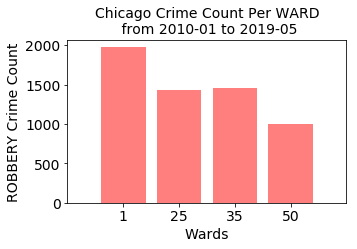

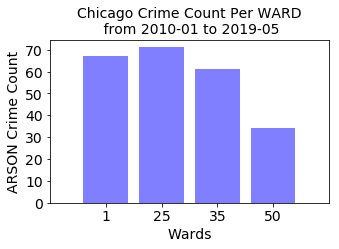

In [16]:
plot_crimes_wards(df = crimes_count_df, plot_type = 'bar', offense_types = ['ROBBERY', 'ARSON'], \
                             wards=[1, 25, 35, 50], years=[2010,2019], from_widget = False)

<Figure size 432x288 with 0 Axes>

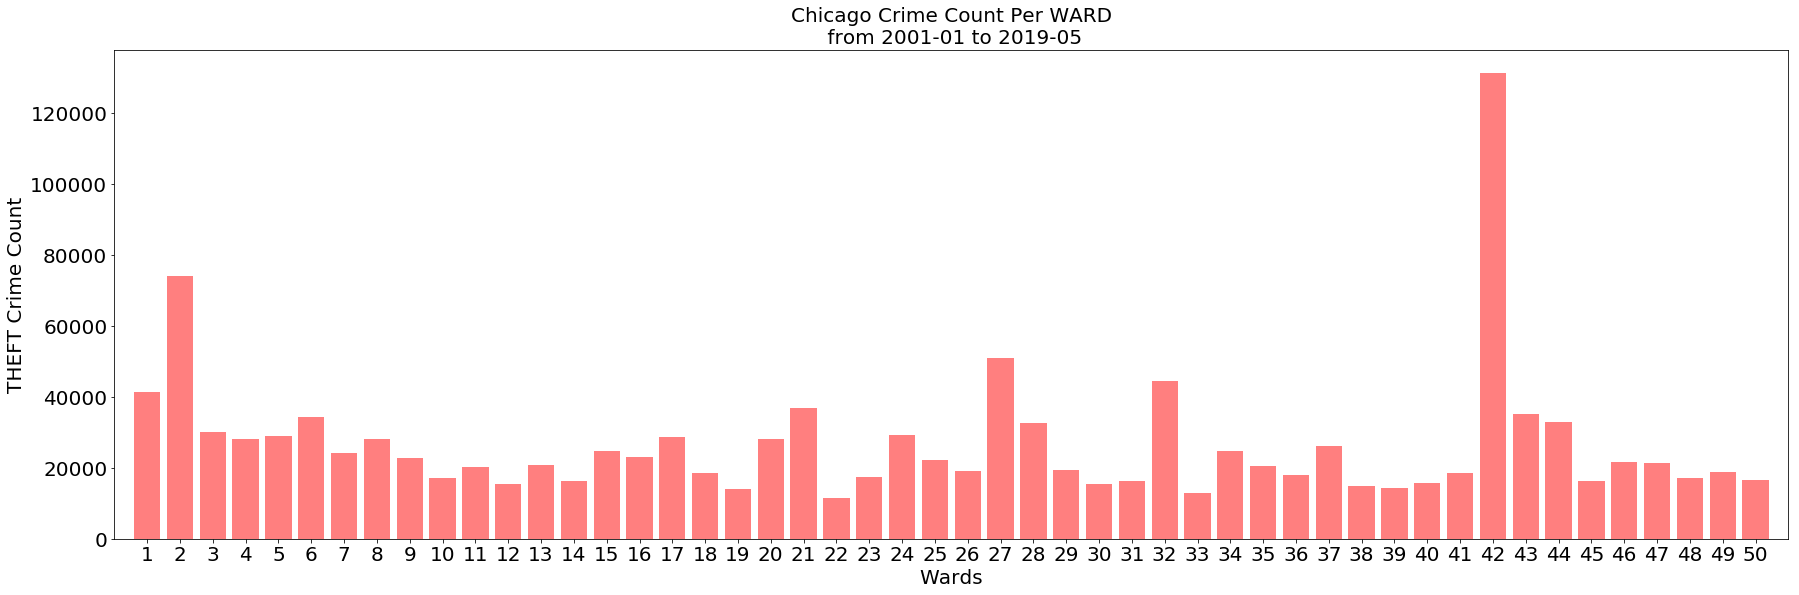

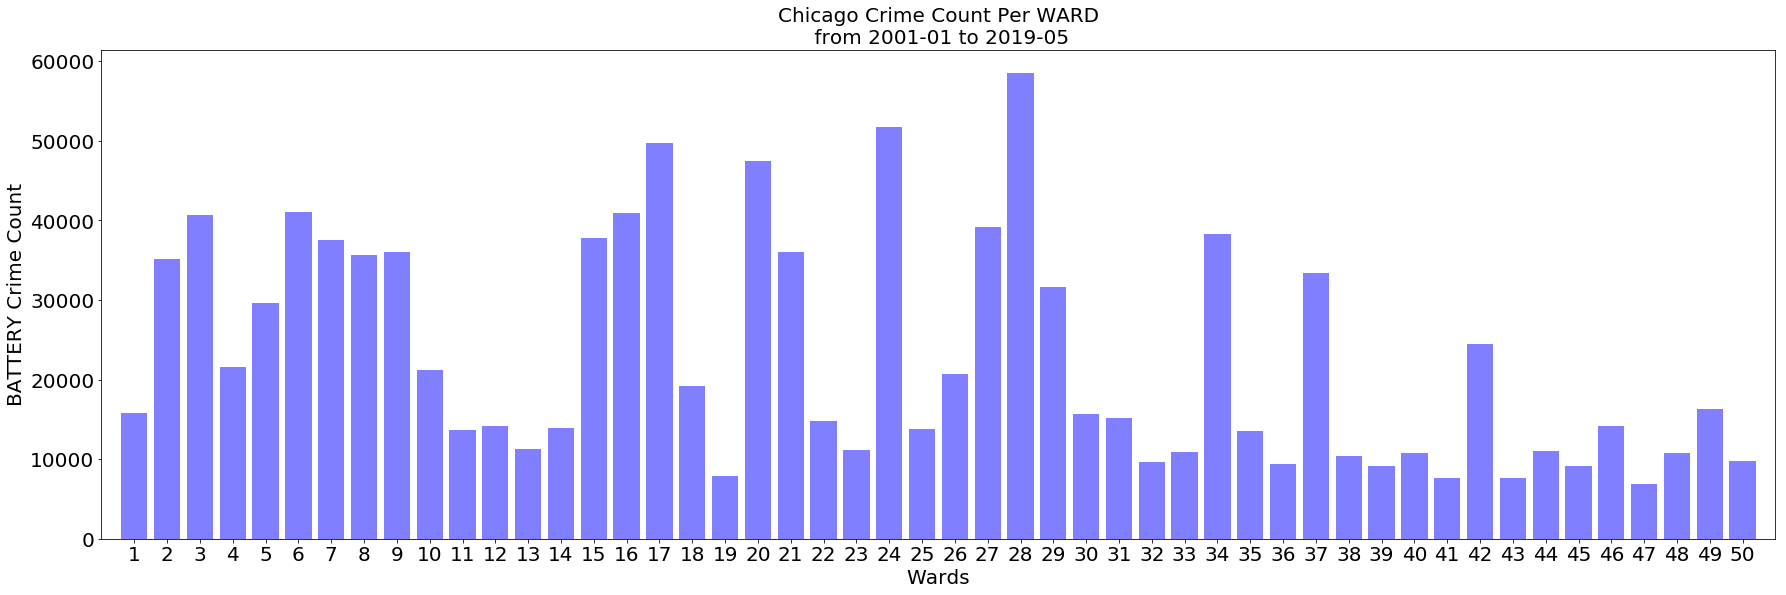

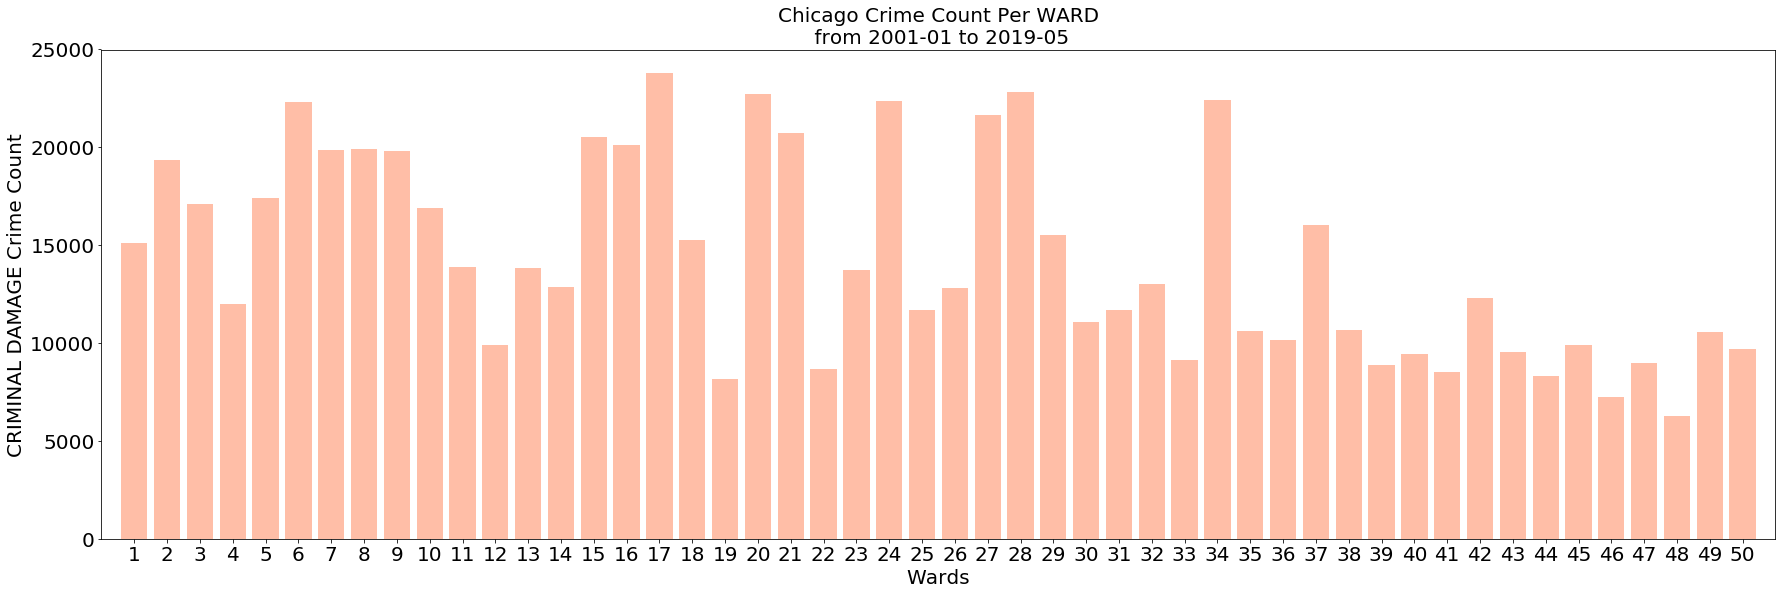

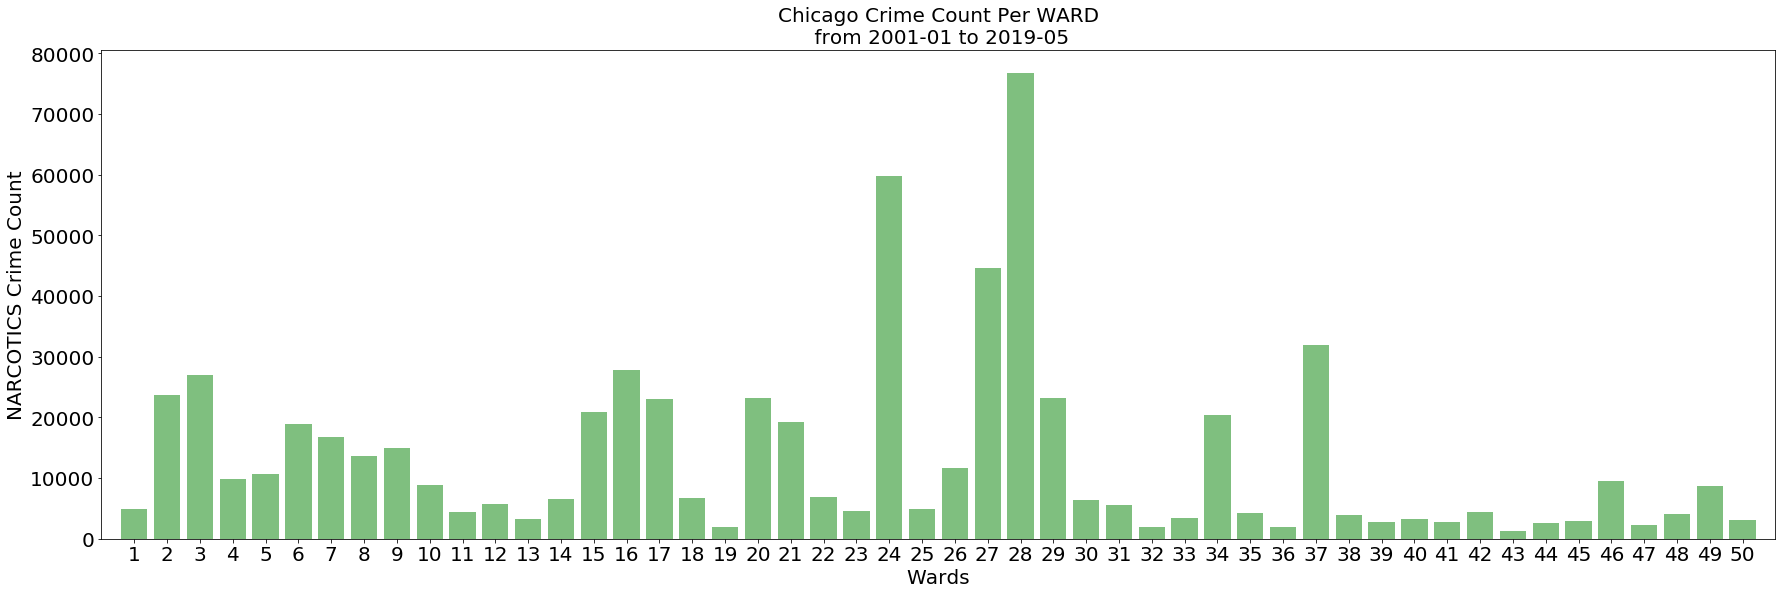

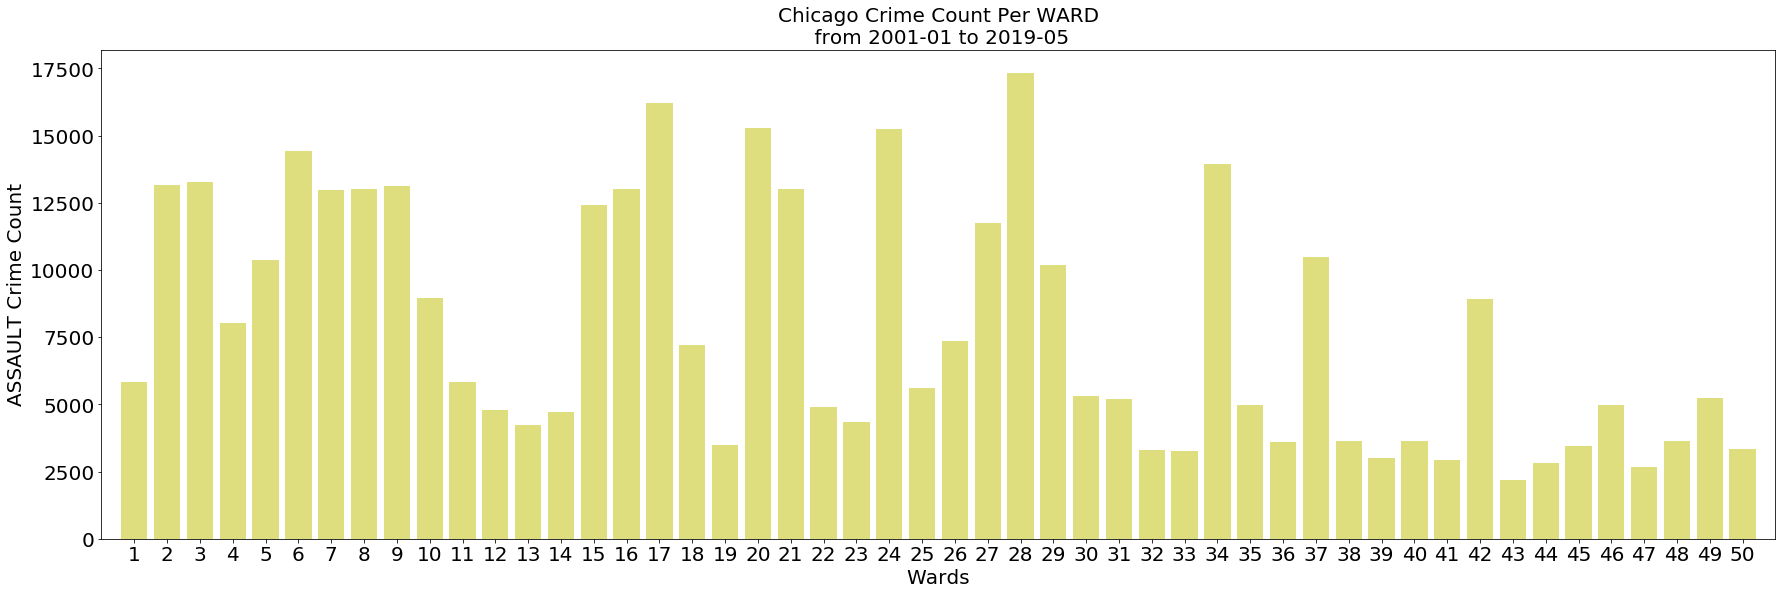

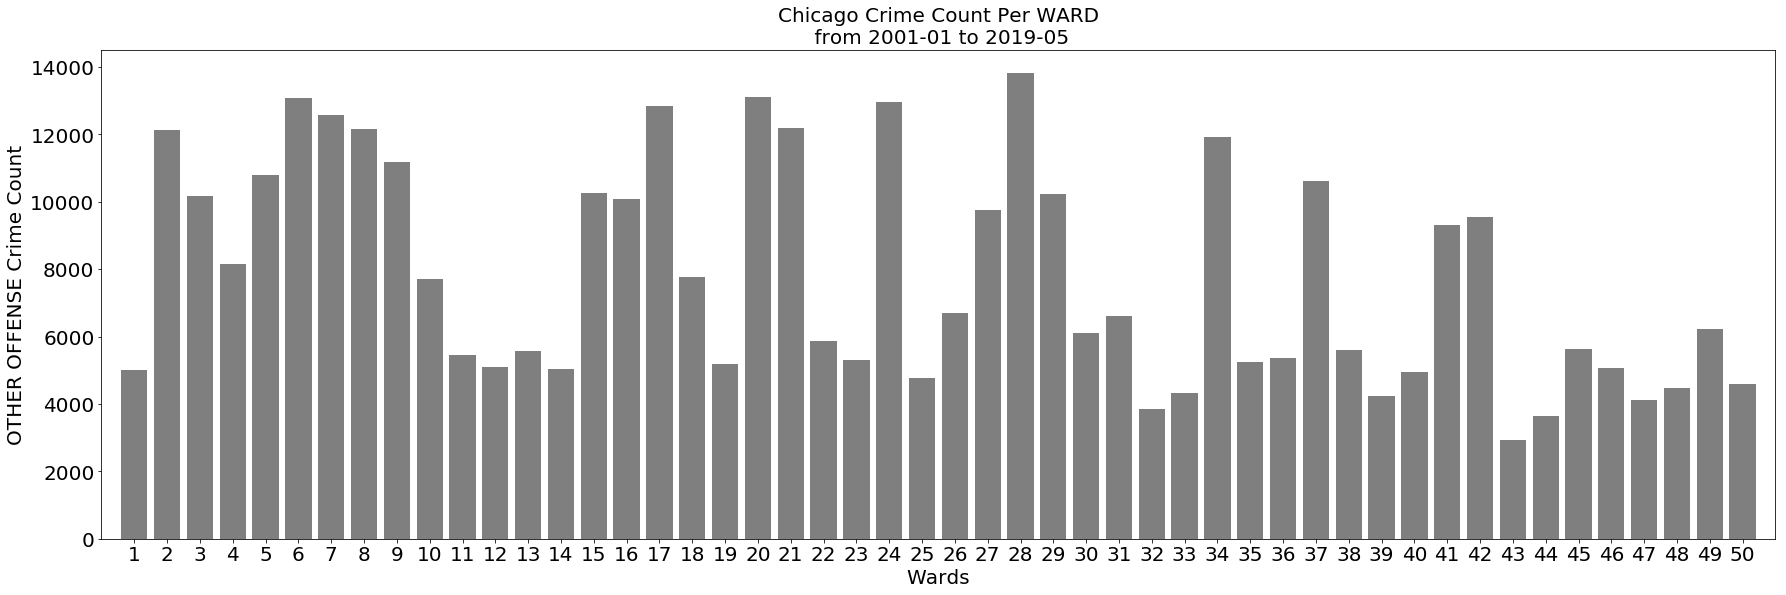

In [17]:
plot_crimes_wards(df = crimes_count_df, plot_type = 'bar', \
     offense_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT', 'OTHER OFFENSE'], \
         wards=[i for i in range(1,51)]  , years=[2001,2019], from_widget = False)

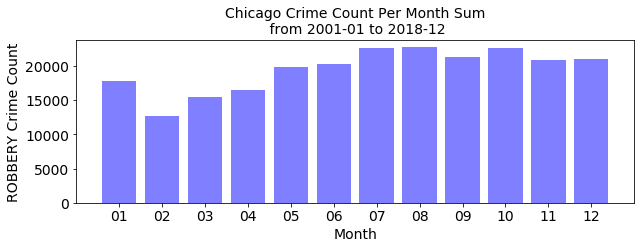

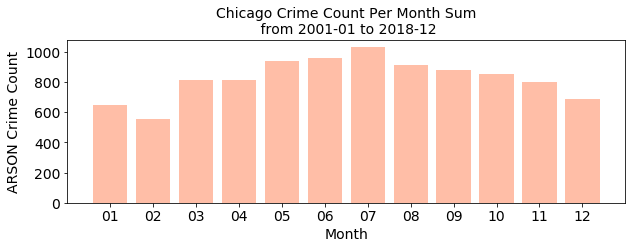

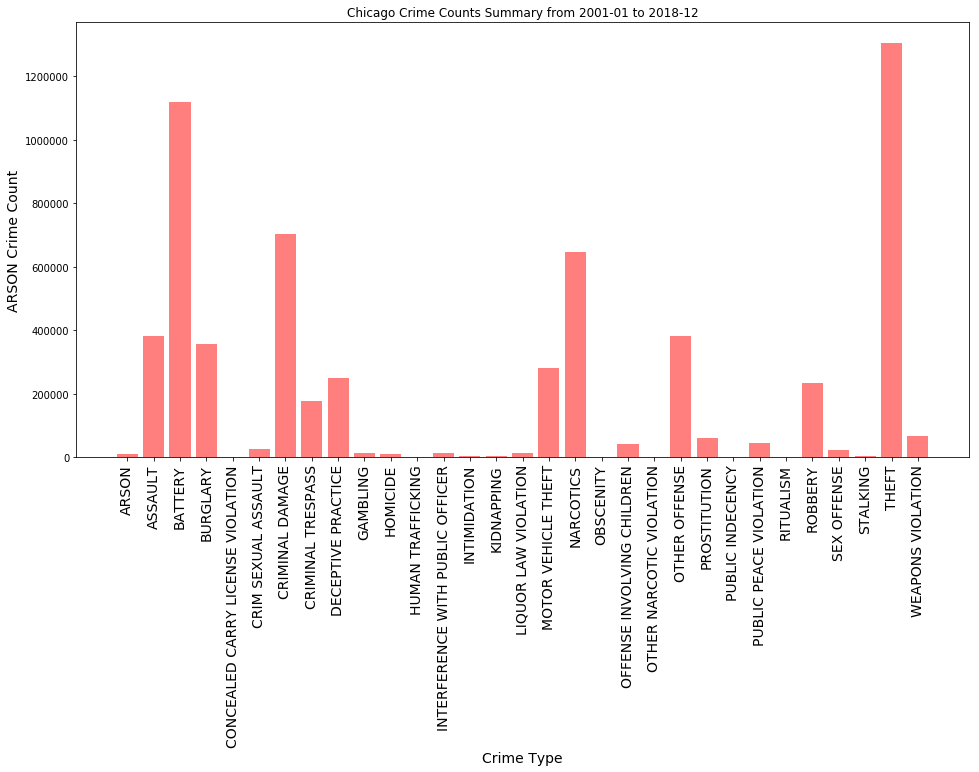

In [31]:
plot_crime_counts(crimes_count_df, plot_type = 'bar2', offense_types = ['ROBBERY', 'ARSON'], years = [ 2001, 2018 ])

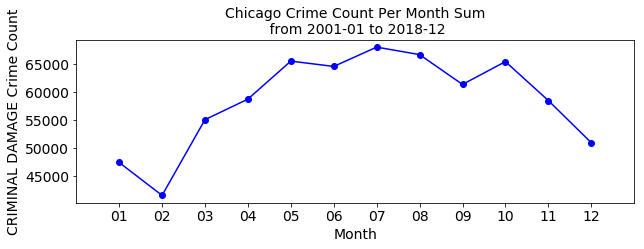

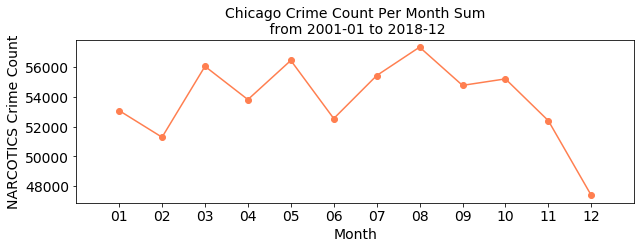

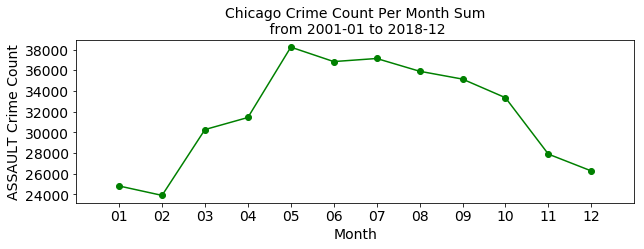

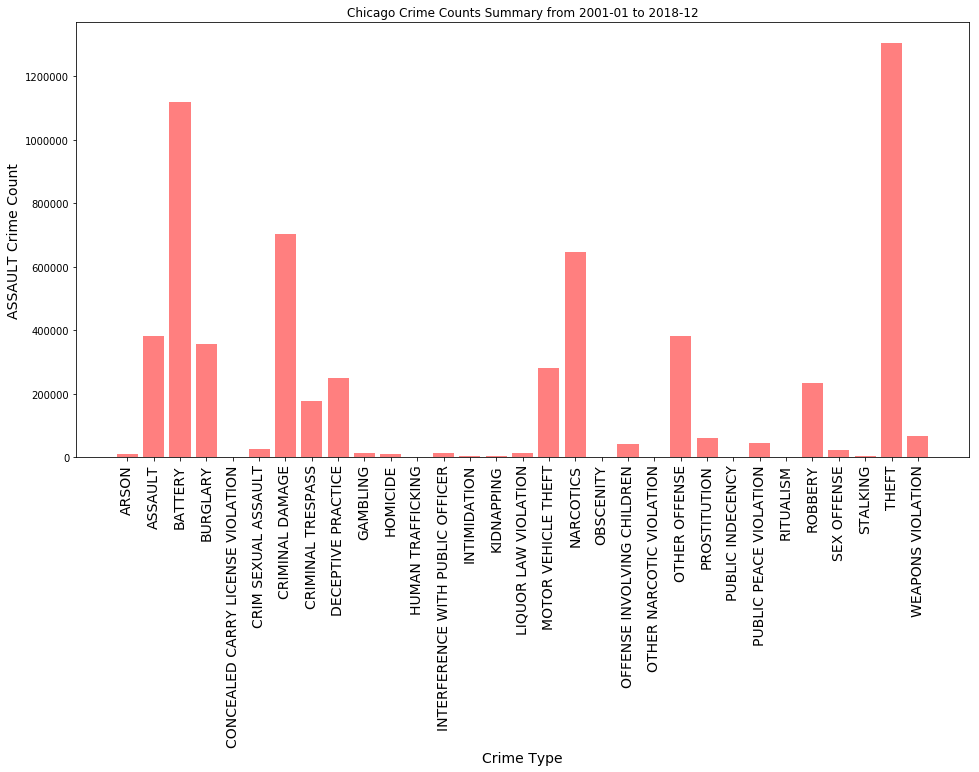

In [32]:
plot_crime_counts(crimes_count_df, plot_type = 'line2', offense_types = ['CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'], years = [ 2001, 2018 ])

<Figure size 432x288 with 0 Axes>

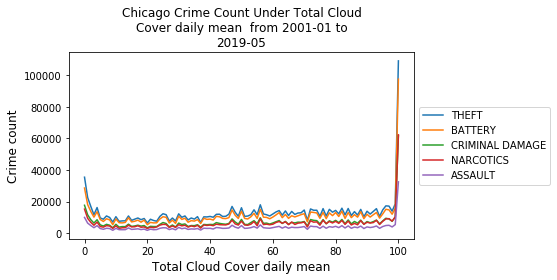

In [19]:
 plot_crime_weather(plot_type = 'line', 
                  offense_types = [ 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT' ] )

<Figure size 432x288 with 0 Axes>

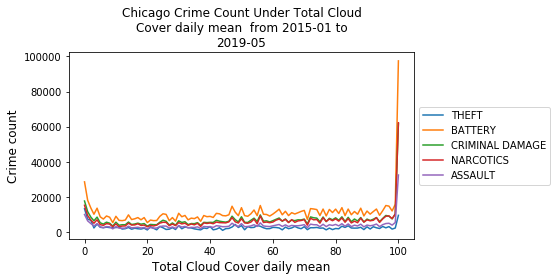

In [20]:
plot_crime_weather(plot_type = 'line', 
                  offense_types = [ 'THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT'],
                  years = [2015,2019])

<Figure size 432x288 with 0 Axes>

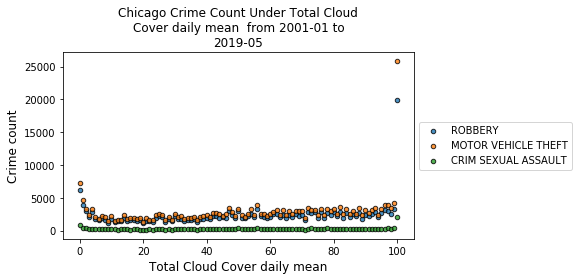

In [21]:
 plot_crime_weather(offense_types = [ 'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT' ] )

<Figure size 432x288 with 0 Axes>

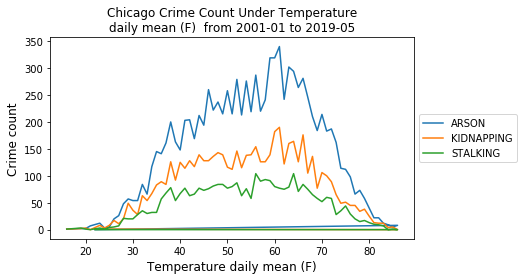

In [22]:
plot_crime_weather( df = crimes_weather_df, plot_type='line', 
                   offense_types = [ 'ARSON', 'KIDNAPPING', 'STALKING'],
                    meas_type = 'Temperature daily mean (F)')

<Figure size 432x288 with 0 Axes>

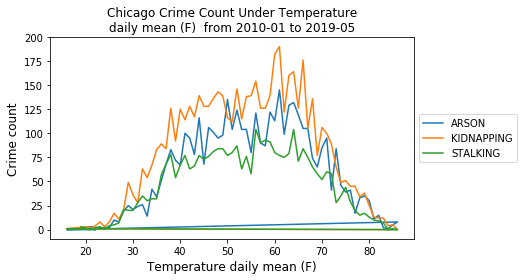

In [23]:
plot_crime_weather( df = crimes_weather_df, plot_type='line', 
                   offense_types = [ 'ARSON', 'KIDNAPPING', 'STALKING'],
                    meas_type = 'Temperature daily mean (F)', years = [2010, 2019])

<Figure size 432x288 with 0 Axes>

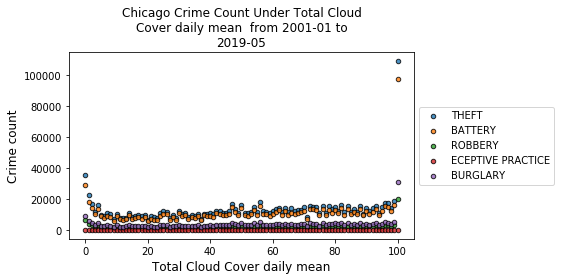

In [24]:
plot_crime_weather( offense_types = ['THEFT', 'BATTERY', 'ROBBERY', 'ECEPTIVE PRACTICE', 'BURGLARY'])

<Figure size 432x288 with 0 Axes>

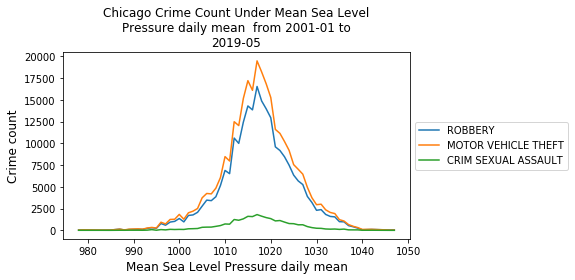

In [25]:
 plot_crime_weather(plot_type='line', offense_types = [ 'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIM SEXUAL ASSAULT' ] ,
                   meas_type = 'Mean Sea Level Pressure daily mean' )

<Figure size 432x288 with 0 Axes>

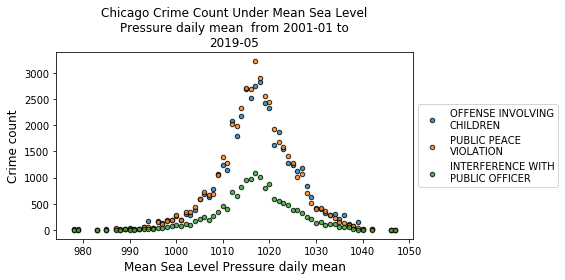

In [26]:
plot_crime_weather(offense_types = [ 'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER' ] ,
                   meas_type = 'Mean Sea Level Pressure daily mean' )